In [1]:
import sys
sys.path.append('..')
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch as t
import torch.nn as nn
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ExpUtils import *
from utils import get_data
t.backends.cudnn.benchmark = True
t.backends.cudnn.enabled = True
seed = 1

In [4]:
args = argparse.Namespace()
args.batch_size = 256
args.buffer_size = 10000
args.data_root = "/shared/imagenet/"
args.dataset = "imagenet"
args.debug = True
args.decay_epochs = [35, 80, 120]
args.decay_rate = 0.1
args.dropout_rate = 0.0
args.load_path = "temp.pt"
args.log_dir = "./runs"
args.lr = 0.0001
args.n_classes = 10
args.n_epochs = 150

# imagenet data

In [5]:
traindir = os.path.join(args.data_root, 'train')
valdir = os.path.join(args.data_root, 'val')
normalize = transforms.Normalize(mean=[0.482, 0.458, 0.408],
                                 std=[0.229, 0.261, 0.276])

crop_size = 224

In [6]:
train_dataset = datasets.ImageFolder(
        traindir,
        transforms.Compose([
            transforms.RandomResizedCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

train_sampler = None
args.workers = 1
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
    num_workers=args.workers, pin_memory=True, sampler=train_sampler)

# LR range test

In [7]:
from torch_lr_finder import LRFinder

## model resnet18 resnet50

In [8]:
from torchvision.models import resnet18, resnet50

## resnet18, different weight_decay

https://github.com/pytorch/examples/tree/master/imagenet  

Official code uses SGD with lr = 0.1

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.61E+00


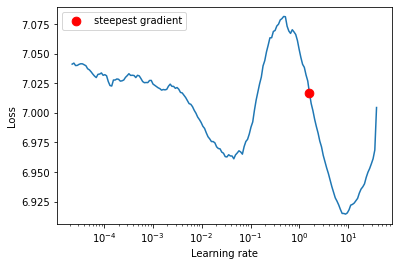

In [9]:
model = resnet18()
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=5e-6)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.41E+00


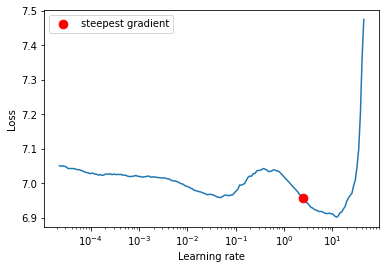

In [10]:
model = resnet18()
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-6)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.07E+00


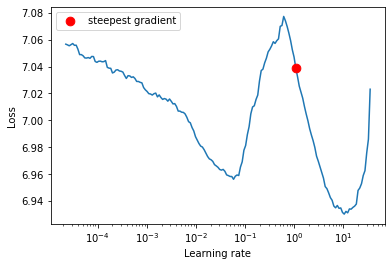

In [11]:
model = resnet18()
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-5)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## resnet50


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.56E-01


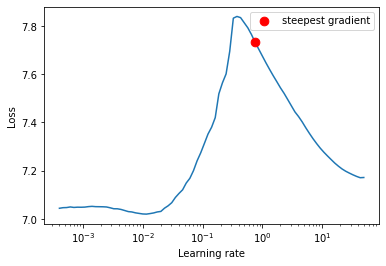

In [12]:
model = resnet50()
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-5)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.05E+00


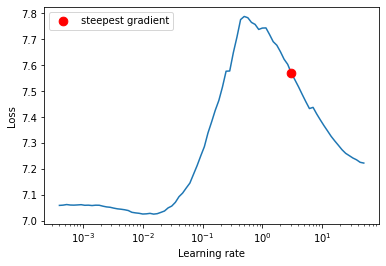

In [13]:
model = resnet50()
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-6)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E+00


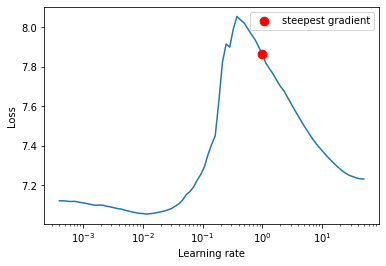

In [14]:
model = resnet50()
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()